# Metaphor Detector for Spanish
Reyes Gago Sosa and Amaia Murillo Lekuona




The effective automated detection of conceptual metaphors poses a significant challenge in NLP tasks due to their subjectivity and abstract nature. This project explores the possibility of detecting them at token labeling level in a binary manner, where a word acts metaphorically compared to its usual meaning. To achieve this, a multilingual language model has been trained in Spanish using the CoMeta dataset, aiming to enhance results through fine-tuning procedures. To evaluate the final performance of the model, a custom dataset consisting of 50 examples has been created. Our experiments show promising results, highlighting the potential of multilingual models in detecting linguistic metaphors across diverse contexts.



First we install the required libraries to carry out the project.

In [ ]:
!pip install transformers[torch]
import transformers

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install datasets

## Pre-processing
We aim to fine-tune [lwachowiak/Metaphor-Detection-XLMR](https://huggingface.co/lwachowiak/Metaphor-Detection-XLMR) model, trained on the VU Amsterdam Metaphor Corpus, which is restricted to English. To this end, we have selected the [CoMeta](https://ixa-ehu.github.io/cometa/), a corpus for metaphor detection in Spanish, which is available in the Datasets library provided by Hugging Face.

In [ ]:
# Load the dataset
from datasets import load_dataset
data = load_dataset("HiTZ/cometa")

The CoMeta dataset comprises only two partitions: train and test.

In [ ]:
train_dataset = data["train"]
test_dataset = data["test"]

In [ ]:
# Show an individual examples within the dataset
data["train"][3]

{'id': 3,
 'tokens': ['Éste',
  'es',
  'el',
  'enfoque',
  'que',
  'ha',
  'defendido',
  'desde',
  'un',
  'principio',
  'mi',
  'Gobierno',
  'y',
  'que',
  'hoy',
  'es',
  'generalmente',
  'compartido',
  'por',
  'los',
  'países',
  'que',
  'componen',
  'la',
  'misión',
  '.'],
 'tags': [0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

We create a function to display random examples for analyzing the dataset structure.

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

As we can see in the following table, our dataset has two columns: 'tokens' and 'tags'. The former contains lists of tokens that make up sentences, while the latter includes lists of tags assigned to each token in the corresponding sentence. In short, each token has a specific label associated with it.

There are two possible labels:
* Label 0 refers to literal usage.
* Label 1 corresponds to metaphoric usage.

In [ ]:
# Display random examples
show_random_elements(data["train"])

,id,tokens,tags
0,2619,"[Las, primeras, bajas, de, los, rebeldes, irlandeses, en, el, alzamiento, fueron, dos, activistas, del, de, el, ICA, en, un, frustrado, intento, de, asedio, del, de, el, Castillo, de, Dublín, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,456,"[Los, jueces, ,, lehendakari, ,, determinan, responsabilidades, penales, o, administrativas, de, las, actuaciones, que, enjuician, ,, pero, no, pueden, significar, una, coartada, ,, ni, para, que, el, Gobierno, evite, la, intervención, de, su, Comisión, de, Ética, ,, ni, para, que, deje, de, asumir, responsabilidades, políticas, y, ,, sobre, todo, ,, los, mandatos, de, este, Parlamento, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,102,"[La, operación, está, sujeta, a, ciertas, ', condiciones, suspensivas, ', ,, como, la, obtención, de, autorizaciones, administrativas, de, acuerdo, con, el, contrato, de, concesión, y, con, la, ley, de, defensa, de, la, competencia, ,, y, a, otros, requisitos, como, la, confirmación, de, los, vendedores, que, deberá, ser, emitida, antes, del, 10, de, octubre, próximo, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1126,"[El, dirigente, de, CCOO, admitió, que, hace, falta, un, socio, tecnológico, que, aumente, las, inversiones, en, investigación, y, desarrollo, y, ayude, a, la, compañía, a, acceder, a, nuevos, mercados, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1003,"[En, más, de, una, ocasión, tuvo, acceso, a, los, paddock, del, de, el, Gran, Premio, de, Inglaterra, en, el, Circuito, de, Silverstone, ,, así, como, en, otros, circuitos, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,914,"[En, 1695, ,, un, grupo, de, indios, teribes, fueron, enviados, a, la, región, de, Boruca, ,, al, a, el, sureste, de, Costa, Rica, ,, y, fundan, el, pueblo, de, San, Francisco, de, Térraba, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,571,"[Usted, ha, hecho, referencia, a, una, parte, de, mi, intervención, y, yo, leo, textualmente, lo, que, dije, y, es, que, ', el, Gobierno, ha, asumido, con, humildad, y, claridad, que, hay, ámbitos, de, la, gestión, de, determinados, patrocinios, que, pueden, ser, mejorados, ', .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,419,"[Obuchi, ,, de, 62, años, ,, sufrió, un, derrame, cerebral, en, la, madrugada, del, día, 2, de, abril, y, ,, tras, permanecer, seis, semanas, en, estado, de, coma, ,, falleció, en, el, hospital, Yuntendo, de, Tokio, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,2771,"[Muchos, de, los, que, estáis, hoy, aquí, conocisteis, a, Miguel, Ángel, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,2233,"[Hasta, ahora, ,, Rayo, y, Deportivo, se, habían, enfrentado, ocho, veces, en, Primera, División, ,, con, un, saldo, de, tres, victorias, del, conjunto, coruñés, y, cinco, empates, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


We load the tokenizer from the model we intend to fine-tune. The tokenizer splits the inputs, converting the tokens to their corresponding IDs in the pre-trained vocabulary, and formats them as the model expects.

In [ ]:
# Load the tokenizer
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("lwachowiak/Metaphor-Detection-XLMR")

In [ ]:
# Tokenize an example to see the output
tokenizer("Estoy ahogada en problemas")

{'input_ids': [0, 157607, 56660, 16531, 22, 12234, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

Next we compare the original tokens with the ones returned by the tokenizer, to observe how the tokenizer processes and represents each word in the original sentence.

In [ ]:
sample = data["train"][5]
print(sample["tokens"])

['Especialistas', 'de', 'las', 'Fuerzas', 'Armadas', 'egipcias', 'afirman', 'que', 'hasta', 'finales', 'de', '1999', 'han', 'eliminado', 'más', 'de', 'dos', 'millones', 'de', 'minas', '.']


In [ ]:
tokenized_input = tokenizer(sample["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['<s>', '▁Especial', 'istas', '▁de', '▁las', '▁Fuerza', 's', '▁Armada', 's', '▁e', 'gip', 'cias', '▁afirma', 'n', '▁que', '▁hasta', '▁finales', '▁de', '▁1999', '▁han', '▁elimina', 'do', '▁más', '▁de', '▁dos', '▁millones', '▁de', '▁mina', 's', '▁', '.', '</s>']


We observe that the tokenizer includes some necessary inputs required by the model, and words that the model does not recognize are split into subtokens. Consequently, as we can see below, the list of input IDs returned by the tokenizer is longer than the list of labels. Therefore, we need to align them.

In [ ]:
len(sample[f"tags"]), len(tokenized_input["input_ids"])

(21, 32)

In [ ]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else sample["tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

32 32


In order to tokenize and align the labels, we will create a function that consists in creating a new label list that reflects the tokenized input structure. For each original word and its resulting subtokens we assign the same label to each subtoken. This way, we ensure a direct correspondence between the input IDs and their respective labels.

In [ ]:
# Assign labels to all tokens, not just to the first token of each word, to ensure that each subtoken receives a label
label_all_tokens = True

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    # Create a new label list to store aligned labels
    labels = []
    for i, label in enumerate(examples[f"tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None, set the label to -100 so they are automatically ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # Set the label for the first token of each word
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, set the label to either the current label or -100, depending on the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        # Append the aligned labels to the labels list
        labels.append(label_ids)

    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Apply the function to some examples
tokenize_and_align_labels(data['train'][:5])

{'input_ids': [[0, 242, 3561, 37421, 115675, 41, 110, 95, 26895, 10, 82633, 1129, 3701, 88, 33362, 6, 5, 2], [0, 357, 18608, 37363, 1538, 533, 182798, 885, 22, 21, 58342, 24668, 581, 89868, 13, 28090, 170852, 6, 5, 2], [0, 20, 20, 2369, 2168, 151, 2168, 6, 5, 2], [0, 10833, 67, 198, 88, 162936, 41, 256, 187727, 246, 3287, 51, 37004, 324, 44744, 113, 41, 12119, 198, 164489, 42215, 246, 196, 388, 18387, 41, 148347, 19, 21, 6, 55611, 6, 5, 2], [0, 17151, 28528, 140323, 72742, 1500, 157846, 136469, 10, 51, 7733, 8, 105799, 7, 41, 21, 100562, 22, 21, 2924, 3290, 4000, 52441, 5977, 41, 13744, 1011, 2924, 3290, 809, 145, 5543, 88, 130205, 8, 388, 17013, 158, 141514, 180291, 6, 4, 5171, 139214, 184, 139214, 40, 196, 21, 162702, 8, 46094, 141514, 113, 41, 164419, 21, 119031, 146, 31357, 12763, 105244, 10, 388, 50871, 123066, 90, 41, 17432, 1397, 95280, 7, 1011, 2924, 3290, 4000, 52441, 5977, 6, 5, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1,

In [ ]:
# Apply the function to all examples in both the training and testing sets
tokenized_datasets = data.map(tokenize_and_align_labels, batched=True)

## Fine-tuning

In this section, now that our data is pre-processed, we proceed to download and fine-tune the [lwachowiak/Metaphor-Detection-XLMR](https://huggingface.co/lwachowiak/Metaphor-Detection-XLMR) model.

In [ ]:
# Mount Google Drive to save the fine-tuned model and training results
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the model we want to fine-tune
model_checkpoint = "lwachowiak/Metaphor-Detection-XLMR"

In [ ]:
# Load the model for token classification
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

To instantiate a `Trainer`, we need to define three main components. First, we have to set the training parameters using `TrainingArguments`.

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# Set the training parameters
model_new = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir="/content/drive/My Drive/Colab Notebooks/trabajo final app1/Results",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

The second component that needs to be defined is the `data_collator`. This is used for batching processed examples together and applying padding to ensuare they are all the same size. The data collator that we will be using for this task can be found in the Transformers library and it not only pads the input sequences but also the corresponding labels.

In [ ]:
from transformers import DataCollatorForTokenClassification

# Initialize a data collator for token classification using the tokenizer
data_collator = DataCollatorForTokenClassification(tokenizer)

The last component is the metric we will use to evaluate the predictions made by our fine-tuned model. Since we are performing token classification, we will load the 'seqeval' metric for sequence labeling evaluation.

In [ ]:
!pip install datasets transformers seqeval

In [ ]:
from datasets import load_metric

#Load the metric
metric = load_metric("seqeval")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Define the label list
label_list = ['O','B-METAPHOR']

During the evaluation stage of token classification, predictions are represented as logits, therefore, to obtain the predicted labels, we need to convert predictions to label selecting the logit with highest probability. Additionaly, during training, some tokens may be ignored, indicated by a label of -100. In the post-processing step, we need to ignore these special labels and only consider valid labels. To this end, we create a function to carry out the post-processing and the utilizes the ``seqeval`` metric for evaluation.

In [ ]:
import numpy as np

def compute_metrics(p):
    # Unpack predictions and labels
    predictions, labels = p
     # Convert predictions to label indices with highest probability
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens) and map indices back to labels
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Compute evaluation metrics using 'seqeval'
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Once we have defined the training parameters, the data collator, and the evaluation metric, we instantiate a `Trainer` object to manage the training process.

In this step, we select the datasets. As we have mentioned earlier, the dataset only has two partitions: train and test. There is no validation set. Consequently, we have used the test set for the validation or `eval_dataset`.

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Now we develop our own metaphor detector for Spanish fine-tuning the original model by calling the `train` method.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.050257,0.712215,0.435995,0.540881,0.981571
2,No log,0.051097,0.666667,0.570342,0.614754,0.982202
3,0.049400,0.056720,0.652602,0.588086,0.618667,0.981950


Checkpoint destination directory /content/drive/My Drive/Colab Notebooks/trabajo final app1/Results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=546, training_loss=0.0476525611493177, metrics={'train_runtime': 248.6075, 'train_samples_per_second': 35.067, 'train_steps_per_second': 2.196, 'total_flos': 444560707420344.0, 'train_loss': 0.0476525611493177, 'epoch': 3.0})

## Evaluation

Since we have used the test set for validation in the previous step, the evaluation results we obtain are the same as those observed during the final epoch, shown in the table above.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.05672011524438858,
 'eval_precision': 0.6526019690576652,
 'eval_recall': 0.5880861850443599,
 'eval_f1': 0.6186666666666667,
 'eval_accuracy': 0.9819495724068289,
 'eval_runtime': 6.1581,
 'eval_samples_per_second': 118.055,
 'eval_steps_per_second': 7.47,
 'epoch': 3.0}

To obtain the precision, recall and F1-score for the label 1, 'B-METAPHOR', we can use the same function as before to analyze the results. In this case is not necessary. As we observe, the results are the same; however,

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print(results)

{'METAPHOR': {'precision': 0.6526019690576652, 'recall': 0.5880861850443599, 'f1': 0.6186666666666667, 'number': 789}, 'overall_precision': 0.6526019690576652, 'overall_recall': 0.5880861850443599, 'overall_f1': 0.6186666666666667, 'overall_accuracy': 0.9819495724068289}


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

# Define true labels and predicted labels
y_true = [label for sublist in true_labels for label in sublist]
y_pred = [label for sublist in true_predictions for label in sublist]

# Calculate precision, recall, and F1-score for each class
precision_b_metaphor = precision_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[0]
recall_b_metaphor = recall_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[0]
f1_b_metaphor = f1_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[0]

precision_o = precision_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[1]
recall_o = recall_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[1]
f1_o = f1_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[1]

# Calculate weighted average of metrics
weighted_precision = precision_score(y_true, y_pred, average='weighted', labels=['B-METAPHOR', 'O'])
weighted_recall = recall_score(y_true, y_pred, average='weighted', labels=['B-METAPHOR', 'O'])
weighted_f1 = f1_score(y_true, y_pred, average='weighted', labels=['B-METAPHOR', 'O'])

# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

# Metrics for 'B-METAPHOR'
print("Precision (B-METAPHOR):", precision_b_metaphor)
print("Recall (B-METAPHOR):", recall_b_metaphor)
print("F1-score (B-METAPHOR):", f1_b_metaphor)

# Metrics for 'O'
print("Precision (O):", precision_o)
print("Recall (O):", recall_o)
print("F1-score (O):", f1_o)

# Weighted metrics
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-score:", weighted_f1)

# Overall metrics
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1)
print("Overall Accuracy:", accuracy)

Precision (B-METAPHOR): 0.6526019690576652
Recall (B-METAPHOR): 0.5880861850443599
F1-score (B-METAPHOR): 0.6186666666666667
Precision (O): 0.9895086835818968
Recall (O): 0.9920064724919094
F1-score (O): 0.9907560037493132
Weighted Precision: 0.9811203028264416
Weighted Recall: 0.9819495724068289
Weighted F1-score: 0.9814916379770197
Overall Precision: 0.8210553263197811
Overall Recall: 0.7900463287681347
Overall F1-score: 0.80471133520799
Overall Accuracy: 0.9819495724068289


In the following step, we create a dataframe with the predicted labels and the true labels so we can compare the results.

In [ ]:
predicted = [' '.join(pred) for pred in true_predictions]
true = [' '.join(label) for label in true_labels]

df = pd.DataFrame({
    'Predicted Labels': predicted,
    'True Labels': true
})

display(df.head(20))

,Predicted Labels,True Labels
0,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,O O O O O O O,O O O O O O O
3,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,O O O O O O O O O O,O O O O O O O O O O
5,O O O O O O B-METAPHOR B-METAPHOR O O O O,O O O O O O B-METAPHOR B-METAPHOR O O O O
6,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...
7,O B-METAPHOR B-METAPHOR B-METAPHOR O O O O O O...,O O O O O O O O O B-METAPHOR O O O O O O O O O...
8,O O O O O O O O O O O O,O O O O O O O O O O O O
9,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...


Additionally, we generate a confusion matrix to observe the correct and incorrect predictions of our model. This way, we can analyze the model's performance in classifying each class.

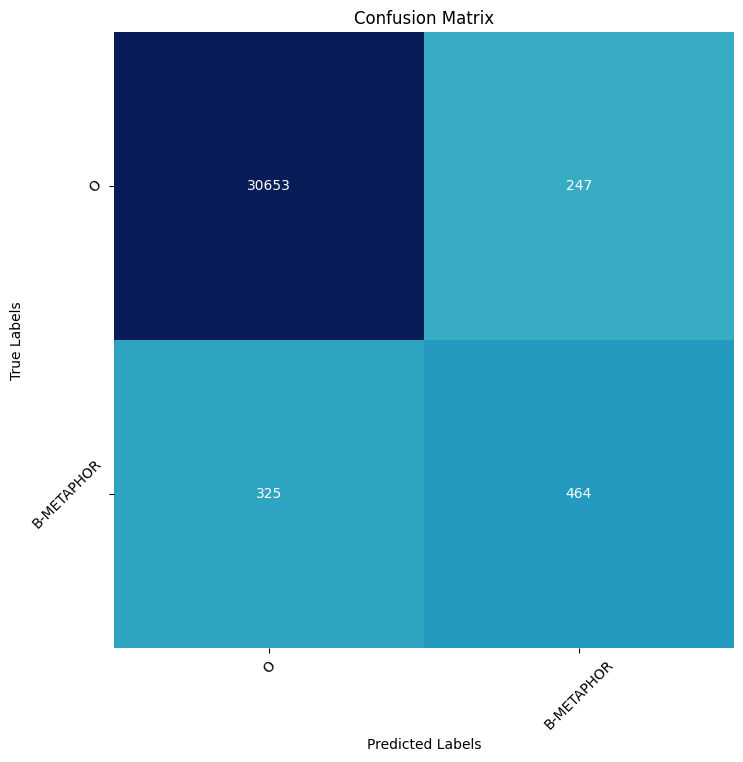

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

flat_true_labels = [label for sublist in true_labels for label in sublist]
flat_predicted_labels = [pred for sublist in true_predictions for pred in sublist]

conf_matrix = confusion_matrix(flat_true_labels, flat_predicted_labels, labels=label_list)
log_norm = LogNorm(vmin=1, vmax=np.max(conf_matrix))

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlGnBu', ax=ax, cbar=False, norm=log_norm)

ax.set_xticklabels(label_list, rotation=45)
ax.set_yticklabels(label_list, rotation=45)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

The confusion matrix shows on its diagonal the true positives, which represent the model's correct predictions. For the 'O' label, we see a high number of correct predictions (30,653), which is expected as most words in a sentence are typically literal, rather than metaphorical. In contrast, for metaphors ('B-METAPHOR'), the model has correctly identified 464 instances, but it has failed to recognize 325 metaphors.

Given this context, the F1-score is the metric we should look at closely here, as the high accuracy might be misleading. The high accuracy rate is influenced by the correct predictions of the 'O' label, since most words are non-metaphorical. However, this metric does not reliably reflect the model's cability in correctly identifying metaphors.


### Experimentation

In this section we will employ our fine-tuned model to detect metaphor using a dataset specifically created for this purpose, which is available at <https://github.com/amaiamurillo/metaphor-detection/blob/main/metaphors.txt> and subsequently conduct a qualitative analysis on its performance.

In [ ]:
from transformers import pipeline

In [ ]:
model_checkpoint = "/content/drive/My Drive/Colab Notebooks/trabajo final app1/Results/checkpoint-500"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("La profunda soledad de Miley Cyrus o por qué cada vez más estrellas del pop se niegan a hacer giras.")

[{'entity_group': 'LABEL_0',
  'score': 0.9999783,
  'word': 'La',
  'start': 0,
  'end': 2},
 {'entity_group': 'LABEL_1',
  'score': 0.8303203,
  'word': 'profunda',
  'start': 3,
  'end': 11},
 {'entity_group': 'LABEL_0',
  'score': 0.99878246,
  'word': 'soledad de Miley Cyrus o por qué cada vez más',
  'start': 12,
  'end': 57},
 {'entity_group': 'LABEL_1',
  'score': 0.80603915,
  'word': 'estrella',
  'start': 58,
  'end': 66},
 {'entity_group': 'LABEL_0',
  'score': 0.9669302,
  'word': 's del pop se niegan a hacer giras.',
  'start': 66,
  'end': 100}]

In [ ]:
token_classifier("En el contexto de la cultura mexicana, noviembre es un mes cargado de significado y celebraciones.")

[{'entity_group': 'LABEL_0',
  'score': 0.9961328,
  'word': 'En el contexto de la cultura mexicana, noviembre es un mes',
  'start': 0,
  'end': 58},
 {'entity_group': 'LABEL_1',
  'score': 0.9761898,
  'word': 'cargado',
  'start': 59,
  'end': 66},
 {'entity_group': 'LABEL_0',
  'score': 0.9994624,
  'word': 'de significado y celebraciones.',
  'start': 67,
  'end': 98}]

In [ ]:
token_classifier("La Policía detiene a 16 personas en Valencia tras desarticular una red criminal dedicada al tráfico de drogas.")

[{'entity_group': 'LABEL_0',
  'score': 0.99987775,
  'word': 'La Policía detiene a 16 personas en Valencia tras',
  'start': 0,
  'end': 49},
 {'entity_group': 'LABEL_1',
  'score': 0.74921566,
  'word': 'desarticular',
  'start': 50,
  'end': 62},
 {'entity_group': 'LABEL_0',
  'score': 0.99995315,
  'word': 'una',
  'start': 63,
  'end': 66},
 {'entity_group': 'LABEL_1',
  'score': 0.98294836,
  'word': 'red',
  'start': 67,
  'end': 70},
 {'entity_group': 'LABEL_0',
  'score': 0.999183,
  'word': 'criminal dedicada al tráfico de drogas.',
  'start': 71,
  'end': 110}]

In [ ]:
token_classifier("Se le pasa el tiempo volando con su juguete.")

[{'entity_group': 'LABEL_0',
  'score': 0.99203753,
  'word': 'Se le pasa el tiempo volando con su juguete.',
  'start': 0,
  'end': 44}]

In [ ]:
token_classifier("Una ingeniera, un arquitecto, un médico y un economista explican el valor de las humanidades en sus disciplinas y lamentan el aislamiento entre las dos ramas del saber.")

[{'entity_group': 'LABEL_0',
  'score': 0.9993261,
  'word': 'Una ingeniera, un arquitecto, un médico y un economista explican el valor de las humanidades en sus disciplinas y lamentan el',
  'start': 0,
  'end': 125},
 {'entity_group': 'LABEL_1',
  'score': 0.8677397,
  'word': 'aislamiento',
  'start': 126,
  'end': 137},
 {'entity_group': 'LABEL_0',
  'score': 0.99986935,
  'word': 'entre las dos',
  'start': 138,
  'end': 151},
 {'entity_group': 'LABEL_1',
  'score': 0.91214997,
  'word': 'ramas',
  'start': 152,
  'end': 157},
 {'entity_group': 'LABEL_0',
  'score': 0.99995035,
  'word': 'del saber.',
  'start': 158,
  'end': 168}]

In [ ]:
token_classifier("El Vaticano exhibe una colección de grabados del siglo XX ocultos durante años por su frágil estado.")

[{'entity_group': 'LABEL_0',
  'score': 0.9986342,
  'word': 'El Vaticano exhibe una colección de grabados del siglo XX ocultos durante años por su',
  'start': 0,
  'end': 85},
 {'entity_group': 'LABEL_1',
  'score': 0.78300476,
  'word': 'frágil',
  'start': 86,
  'end': 92},
 {'entity_group': 'LABEL_0',
  'score': 0.99945605,
  'word': 'estado.',
  'start': 93,
  'end': 100}]

In [ ]:
token_classifier("Los gatos también destacan por la necesidad de querer saciar su curiosidad.")

[{'entity_group': 'LABEL_0',
  'score': 0.9986231,
  'word': 'Los gatos también destacan por la necesidad de querer',
  'start': 0,
  'end': 53},
 {'entity_group': 'LABEL_1',
  'score': 0.9640057,
  'word': 'saciar',
  'start': 54,
  'end': 60},
 {'entity_group': 'LABEL_0',
  'score': 0.9997597,
  'word': 'su curiosidad.',
  'start': 61,
  'end': 75}]

In [ ]:
token_classifier("Una madre de 42 años decide acabar con su vida, ahogada en problemas personales.")

[{'entity_group': 'LABEL_0',
  'score': 0.9990559,
  'word': 'Una madre de 42 años decide acabar con su vida,',
  'start': 0,
  'end': 47},
 {'entity_group': 'LABEL_1',
  'score': 0.9966601,
  'word': 'ahogada',
  'start': 48,
  'end': 55},
 {'entity_group': 'LABEL_0',
  'score': 0.9997977,
  'word': 'en problemas personales.',
  'start': 56,
  'end': 80}]

In [ ]:
token_classifier("Nueve de cada diez está abierto a nuevas oportunidades laborales.")

[{'entity_group': 'LABEL_0',
  'score': 0.9999576,
  'word': 'Nueve de cada diez está',
  'start': 0,
  'end': 23},
 {'entity_group': 'LABEL_1',
  'score': 0.98894006,
  'word': 'abierto',
  'start': 24,
  'end': 31},
 {'entity_group': 'LABEL_0',
  'score': 0.9996335,
  'word': 'a nuevas oportunidades laborales.',
  'start': 32,
  'end': 65}]

In [ ]:
token_classifier("En las entrañas de la fábrica gallega donde se diseña la primera constelación de satélites 5G española.")

[{'entity_group': 'LABEL_0',
  'score': 0.99938345,
  'word': 'En las',
  'start': 0,
  'end': 6},
 {'entity_group': 'LABEL_1',
  'score': 0.65876746,
  'word': 'entrañas',
  'start': 7,
  'end': 15},
 {'entity_group': 'LABEL_0',
  'score': 0.9993682,
  'word': 'de la fábrica gallega donde se diseña la primera constelación de satélites 5G española.',
  'start': 16,
  'end': 103}]

In [ ]:
token_classifier("¿Cómo se sale de las relaciones tóxicas y del sufrimiento?.")

[{'entity_group': 'LABEL_0',
  'score': 0.9999501,
  'word': '¿Cómo se',
  'start': 0,
  'end': 8},
 {'entity_group': 'LABEL_1',
  'score': 0.9677142,
  'word': 'sale',
  'start': 9,
  'end': 13},
 {'entity_group': 'LABEL_0',
  'score': 0.9951791,
  'word': 'de las relaciones tóxicas y del sufrimiento?.',
  'start': 14,
  'end': 59}]

In [ ]:
token_classifier("El Parlamento Europeo ha decidido empezar una lucha contra el 'scroll infinito' para que los usuarios dejen de perder el tiempo en redes sociales.")

[{'entity_group': 'LABEL_0',
  'score': 0.9997564,
  'word': 'El Parlamento Europeo ha decidido empezar una',
  'start': 0,
  'end': 45},
 {'entity_group': 'LABEL_1',
  'score': 0.9942168,
  'word': 'lucha',
  'start': 46,
  'end': 51},
 {'entity_group': 'LABEL_0',
  'score': 0.99898815,
  'word': "contra el '",
  'start': 52,
  'end': 63},
 {'entity_group': 'LABEL_1',
  'score': 0.7626455,
  'word': 'scroll',
  'start': 63,
  'end': 69},
 {'entity_group': 'LABEL_0',
  'score': 0.9802091,
  'word': "infinito' para que los usuarios dejen de perder el tiempo en redes sociales.",
  'start': 70,
  'end': 146}]

In [ ]:
token_classifier("Hasta en ese caso, después de haber conquistado la confianza de la tribu, cuesta mucho trabajo a dichos autores anotar las canciones y ceremonias.")

[{'entity_group': 'LABEL_0',
  'score': 0.99984777,
  'word': 'Hasta en ese caso, después de haber',
  'start': 0,
  'end': 35},
 {'entity_group': 'LABEL_1',
  'score': 0.5171971,
  'word': 'conquista',
  'start': 36,
  'end': 45},
 {'entity_group': 'LABEL_0',
  'score': 0.97630435,
  'word': 'do la confianza de la tribu, cuesta mucho trabajo a dichos autores anotar las canciones y ceremonias.',
  'start': 45,
  'end': 146}]

In [ ]:
token_classifier("El PP pide a Page dejar las palabras huecas, es el momento de plantar batalla.")

[{'entity_group': 'LABEL_0',
  'score': 0.9995135,
  'word': 'El PP pide a Page dejar las palabras',
  'start': 0,
  'end': 36},
 {'entity_group': 'LABEL_1',
  'score': 0.9461682,
  'word': 'huecas',
  'start': 37,
  'end': 43},
 {'entity_group': 'LABEL_0',
  'score': 0.9999698,
  'word': ', es el momento de',
  'start': 43,
  'end': 61},
 {'entity_group': 'LABEL_1',
  'score': 0.9826103,
  'word': 'plantar batalla',
  'start': 62,
  'end': 77},
 {'entity_group': 'LABEL_0',
  'score': 0.99997544,
  'word': '.',
  'start': 77,
  'end': 78}]

In [ ]:
token_classifier("Érguete lo cobijó cuando él cayó en el vicio de la droga y le ayudó a salir.")

[{'entity_group': 'LABEL_0',
  'score': 0.9914104,
  'word': 'Érguete lo cobijó cuando él',
  'start': 0,
  'end': 27},
 {'entity_group': 'LABEL_1',
  'score': 0.9311057,
  'word': 'cayó',
  'start': 28,
  'end': 32},
 {'entity_group': 'LABEL_0',
  'score': 0.9513795,
  'word': 'en el vicio de la droga y le ayudó a salir.',
  'start': 33,
  'end': 76}]

In [ ]:
token_classifier("Érguete lo cobijó cuando él cayó en la droga y le ayudó a salir.")

[{'entity_group': 'LABEL_0',
  'score': 0.9839645,
  'word': 'Érguete lo cobijó cuando él cayó en la droga y le ayudó a salir.',
  'start': 0,
  'end': 64}]

In [ ]:
token_classifier("Uno de los mayores temores de alguien que está pasando por una etapa difícil es acabar cayendo en depresión.")

[{'entity_group': 'LABEL_0',
  'score': 0.9932612,
  'word': 'Uno de los mayores temores de alguien que está pasando por una etapa difícil es acabar',
  'start': 0,
  'end': 86},
 {'entity_group': 'LABEL_1',
  'score': 0.9397952,
  'word': 'cayendo',
  'start': 87,
  'end': 94},
 {'entity_group': 'LABEL_0',
  'score': 0.9686736,
  'word': 'en depresión.',
  'start': 95,
  'end': 108}]

In [ ]:
token_classifier("Érguete lo cobijó cuando él cayó en el vicio de la droga.")

[{'entity_group': 'LABEL_0',
  'score': 0.9518739,
  'word': 'Érguete lo cobijó cuando él',
  'start': 0,
  'end': 27},
 {'entity_group': 'LABEL_1',
  'score': 0.99539316,
  'word': 'cayó',
  'start': 28,
  'end': 32},
 {'entity_group': 'LABEL_0',
  'score': 0.98110044,
  'word': 'en el vicio de la droga.',
  'start': 33,
  'end': 57}]

### Evaluation of the experiment
After having observed the model's performance across several representative examples from out dataset, we are going to create a dataframe consisting of the sentences, the tokens of these sentences, the corresponding labels for each token, and the predictions made by out model. Finally, we will compare the true labels and the predicted ones in order to assess the model's abilty to identify metaphors in Spanish.

In [ ]:
import pandas as pd

file_path = "/content/drive/My Drive/Colab Notebooks/trabajo final app1/Dataset/metaphors def.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

    sentences = []
    tokens_list = []
    labels_list = []

    tokens = []
    labels = []
    for line in lines:
        # Check if the line is not empty
        if line.strip() == '':
            if tokens:  # Ensures empty sentences are not added
                sentences.append(' '.join(tokens))
                tokens_list.append(tokens)
                labels_list.append(labels)
                tokens = []
                labels = []
        else:
            parts = line.strip().split('\t')
            if len(parts) == 2:  # Checks if the line has two parts
                tokens.append(parts[0])
                labels.append(parts[1])
    # To add the last sentence if the file does not end on an empty line
    if tokens:
        sentences.append(' '.join(tokens))
        tokens_list.append(tokens)
        labels_list.append(labels)

# Creating the DataFrame
df = pd.DataFrame({
    'sentences': sentences,
    'tokens': tokens_list,
    'labels': labels_list
})

In [ ]:
display(df)

,sentences,tokens,labels
0,Nuestra percepción del tiempo acaba siendo det...,"[Nuestra, percepción, del, tiempo, acaba, sien...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,Cáritas lucha contra los problemas de salud me...,"[Cáritas, lucha, contra, los, problemas, de, s...","[O, B-METAPHOR, O, O, O, O, O, O, O, O, O, O, O]"
2,No hay más remedio que levantar ese ánimo .,"[No, hay, más, remedio, que, levantar, ese, án...","[O, O, O, O, O, B-METAPHOR, O, O, O]"
3,La del cambio climático es la desconexión de l...,"[La, del, cambio, climático, es, la, desconexi...","[O, O, O, O, O, O, B-METAPHOR, O, O, O, O, O, ..."
4,"En el contexto de la cultura mexicana , noviem...","[En, el, contexto, de, la, cultura, mexicana, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-METAPHO..."
5,El financiero catalán tiene una idea brillante...,"[El, financiero, catalán, tiene, una, idea, br...","[O, O, O, O, O, O, B-METAPHOR, O, O, O, B-META..."
6,El Senado tumba los objetivos de déficit y lle...,"[El, Senado, tumba, los, objetivos, de, défici...","[O, O, B-METAPHOR, O, O, O, O, O, B-METAPHOR, ..."
7,La Policía detiene a 16 personas en Valencia t...,"[La, Policía, detiene, a, 16, personas, en, Va...","[O, O, B-METAPHOR, O, O, O, O, O, O, B-METAPHO..."
8,Se le pasa el tiempo volando con su juguete .,"[Se, le, pasa, el, tiempo, volando, con, su, j...","[O, O, B-METAPHOR, O, O, B-METAPHOR, O, O, O, O]"
9,Un nuevo estudio demuestra que el humor negro ...,"[Un, nuevo, estudio, demuestra, que, el, humor...","[O, O, O, O, O, O, O, B-METAPHOR, O, O, O, O, ..."


The model's output provides detailed information for each identified entity, including the label, confidence score, the words it encompasses, and its position in the text. However, for our analysis and comparison with true labels, we require a simpler format. In order to match the model's output with the format of the true labels for evaluation, we create a function to process the output.

In [ ]:
def process_output(sentence, classification_result):
    # Mapping from entity_group to labels
    label_mapping = {
        "LABEL_0": "O",
        "LABEL_1": "B-METAPHOR",
    }

    tokens = sentence.split()

    # List to store labels for each token
    token_labels = []

    # Index to track the current position in the token list
    current_token_index = 0

    for entity in classification_result:
        # Get the corresponding label
        label = label_mapping[entity['entity_group']]

        # Calculate how many tokens this entity spans
        entity_tokens = entity['word'].split()
        entity_length = len(entity_tokens)

        # Ensure the index does not overflow
        entity_length = min(entity_length, len(tokens) - current_token_index)

        # Assign the label to each token within the entity
        for _ in range(entity_length):
            token_labels.append(label)
            current_token_index += 1

    # Ensure all tokens have labels
    while current_token_index < len(tokens):
        token_labels.append("O")  # Assume any token not covered by an entity is 'O'
        current_token_index += 1

    return token_labels

# Example
sentence = "The deep loneliness of Miley Cyrus or why more and more pop stars refuse to go on tour."
classification_result = token_classifier(sentence)  # This would be your classifier's output
processed_labels = process_output(sentence, classification_result)

print(processed_labels)

['O', 'B-METAPHOR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Now we apply the function we have just created to each sentence in our dataset. Then we add the predicted labels in the required format as a new column. This allows us to compare them with the true labels.

In [ ]:
predicted_labels_list = []

for sentence in df['sentences']:
    # Classify the sentence
    classification_result = token_classifier(sentence)
    # Process the classification result to obtain token-level labels
    processed_labels = process_output(sentence, classification_result)
    # Add the processed result to the list of predicted labels
    predicted_labels_list.append(processed_labels)

# Add the predicted labels as a new column
df['predicted_labels'] = predicted_labels_list

In [ ]:
df

,sentences,tokens,labels,predicted_labels
0,Nuestra percepción del tiempo acaba siendo det...,"[Nuestra, percepción, del, tiempo, acaba, sien...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,Cáritas lucha contra los problemas de salud me...,"[Cáritas, lucha, contra, los, problemas, de, s...","[O, B-METAPHOR, O, O, O, O, O, O, O, O, O, O, O]","[O, B-METAPHOR, O, O, O, O, O, O, O, O, O, O, O]"
2,No hay más remedio que levantar ese ánimo .,"[No, hay, más, remedio, que, levantar, ese, án...","[O, O, O, O, O, B-METAPHOR, O, O, O]","[O, O, O, O, O, B-METAPHOR, O, O, O]"
3,La del cambio climático es la desconexión de l...,"[La, del, cambio, climático, es, la, desconexi...","[O, O, O, O, O, O, B-METAPHOR, O, O, O, O, O, ...","[O, O, O, O, O, O, B-METAPHOR, O, O, O, O, O, ..."
4,"En el contexto de la cultura mexicana , noviem...","[En, el, contexto, de, la, cultura, mexicana, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-METAPHO...","[O, O, O, O, O, O, O, O, O, O, O, O, B-METAPHO..."
5,El financiero catalán tiene una idea brillante...,"[El, financiero, catalán, tiene, una, idea, br...","[O, O, O, O, O, O, B-METAPHOR, O, O, O, B-META...","[O, O, O, O, O, O, B-METAPHOR, O, O, O, B-META..."
6,El Senado tumba los objetivos de déficit y lle...,"[El, Senado, tumba, los, objetivos, de, défici...","[O, O, B-METAPHOR, O, O, O, O, O, B-METAPHOR, ...","[O, O, B-METAPHOR, O, O, O, O, O, B-METAPHOR, ..."
7,La Policía detiene a 16 personas en Valencia t...,"[La, Policía, detiene, a, 16, personas, en, Va...","[O, O, B-METAPHOR, O, O, O, O, O, O, B-METAPHO...","[O, O, O, O, O, O, O, O, O, B-METAPHOR, O, B-M..."
8,Se le pasa el tiempo volando con su juguete .,"[Se, le, pasa, el, tiempo, volando, con, su, j...","[O, O, B-METAPHOR, O, O, B-METAPHOR, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O]"
9,Un nuevo estudio demuestra que el humor negro ...,"[Un, nuevo, estudio, demuestra, que, el, humor...","[O, O, O, O, O, O, O, B-METAPHOR, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, B-METAPHOR, O, O, ..."


Before visualizing the model's predictions with a confusion matrix, we compute the metrics, focusing on precision, recall and F1-score for the 'B-METAPHOR' label.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

# Define the real and predicted labels
y_true = [label for sublist in df['labels'] for label in sublist]
y_pred = [label for sublist in df['predicted_labels'] for label in sublist]

# Calculate precision, recall, and F1-score for each class
precision_b_metaphor = precision_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[0]
recall_b_metaphor = recall_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[0]
f1_b_metaphor = f1_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[0]

precision_o = precision_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[1]
recall_o = recall_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[1]
f1_o = f1_score(y_true, y_pred, labels=['B-METAPHOR', 'O'], average=None)[1]

# Metrics for 'B-METAPHOR'
print("Precision (B-METAPHOR):", precision_b_metaphor)
print("Recall (B-METAPHOR):", recall_b_metaphor)
print("F1-score (B-METAPHOR):", f1_b_metaphor)

# Metrics for 'O'
print("Precision (O):", precision_o)
print("Recall (O):", recall_o)
print("F1-score (O):", f1_o)

Precision (B-METAPHOR): 0.8653846153846154
Recall (B-METAPHOR): 0.6617647058823529
F1-score (B-METAPHOR): 0.75
Precision (O): 0.9741863075196409
Recall (O): 0.992
F1-score (O): 0.9830124575311439


Finally, we will generate a confusion matrix in order to analyze the correct and incorrect predictions of our model.

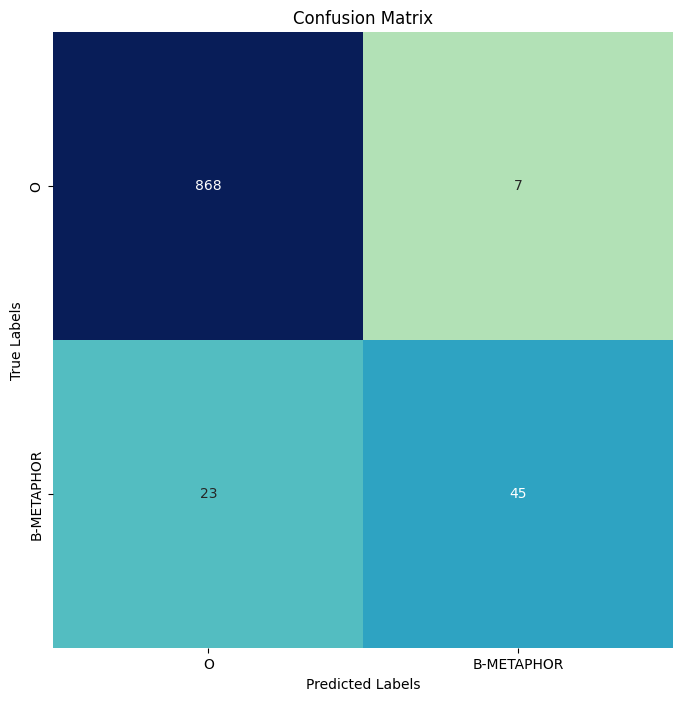

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LogNorm

label_list = ['O', 'B-METAPHOR']

# Flatten the lists of true and predicted labels
flat_true_labels = [label for sublist in df['labels'] for label in sublist]
flat_predicted_labels = [label for sublist in df['predicted_labels'] for label in sublist]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_predicted_labels, labels=label_list)

# Apply logarithmic normalization
log_norm = LogNorm(vmin=1, vmax=np.max(conf_matrix))

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlGnBu', ax=ax, cbar=False, norm=log_norm)

ax.set_xticklabels(label_list)
ax.set_yticklabels(label_list)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

If we focus on the 'B-METAPHOR' label, out of a total of 68 instances, the model correctly identified 45 metaphors. However, it missed 23. This indicates that the model captured approximately 66.18% of the metaphors.